In [26]:
from PIL import Image
import os
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
GTSRB_PATH  = r'/tf/NEXTBASE/GTSRB/Training/'


Helper Functions: 

In [3]:
def list_files_recursive(path, extension):
    extension = extension.lower()
    return [str(p) for p in Path(path).rglob(f"*{extension}")]


def build_ppm_dataframe(file_list):
    """
    Build a pandas DataFrame containing class label, series number,
    image number, and full filepath from PPM file paths.
    """
    records = []

    for path in file_list:
        norm_path = os.path.normpath(path)

        # Extract class label (directory after 'Training')
        class_label = norm_path.split(os.sep)[-2]

        # Extract filename
        filename = os.path.basename(norm_path)  # e.g.: '00000_00000.ppm'

        # Remove extension and split series/image ids
        name_no_ext = filename.replace(".ppm", "")  # '00000_00000'
        series_num, image_num = name_no_ext.split('_')

        records.append({
            "class_label": class_label,
            "series_number": series_num,
            "image_number": image_num,
            "filepath": path
        })

    # Create DataFrame
    df = pd.DataFrame(records)
    return df


def show_mosaic(file_list, mosaic_size=(10, 30), image_size=(64, 64)):
    """
    Display a mosaic of images from a list of PPM files.

    Args:
        file_list (list): list of file paths to PPM images
        mosaic_size (tuple): (number of rows, number of columns) in the mosaic
        image_size (tuple): (width, height) to resize each image
    """
    n_images = mosaic_size[0] * mosaic_size[1]
    selected_files = file_list[:n_images]  # take only the first n images
    
    # Create an empty mosaic array
    rows, cols = mosaic_size
    img_height, img_width = image_size
    mosaic = np.zeros((rows * img_height, cols * img_width, 3), dtype=np.uint8)
    
    for idx, file in enumerate(selected_files):
        # Open the image, convert to RGB - not necessary, and resize
        img = Image.open(file).convert('RGB').resize(image_size)
        row = idx // cols
        col = idx % cols
        # Place the image in the mosaic
        mosaic[row*img_height:(row+1)*img_height, col*img_width:(col+1)*img_width] = np.array(img)
    
    # Display the mosaic
    plt.figure(figsize=(12, 12))
    plt.imshow(mosaic)
    plt.axis('off')
    plt.show()

def plot_class_histogram_from_df(df):
    """
    Plot a histogram of sample counts per class from the PPM dataframe,
    and return the counts as a pandas DataFrame.
    
    Args:
        df (DataFrame): DataFrame containing at least the column 'class_label'
    
    Returns:
        DataFrame: with columns ['class_label', 'count']
    """
    # Count samples per class
    counts = df['class_label'].value_counts().sort_index()

    # Create histogram plot
    plt.figure(figsize=(12, 6))
    plt.bar(counts.index, counts.values)
    plt.xlabel("Class label")
    plt.ylabel("Number of samples")
    plt.title("Histogram of samples per class")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Return DataFrame version
    result_df = pd.DataFrame({
        "class_label": counts.index,
        "count": counts.values
    })

    return result_df


Take a look at the dataset:
- list .ppm and .csv files
- visualize a chunk of data
- plot the class histogram


number of .ppm files: 26640,
number of .csv files: 45



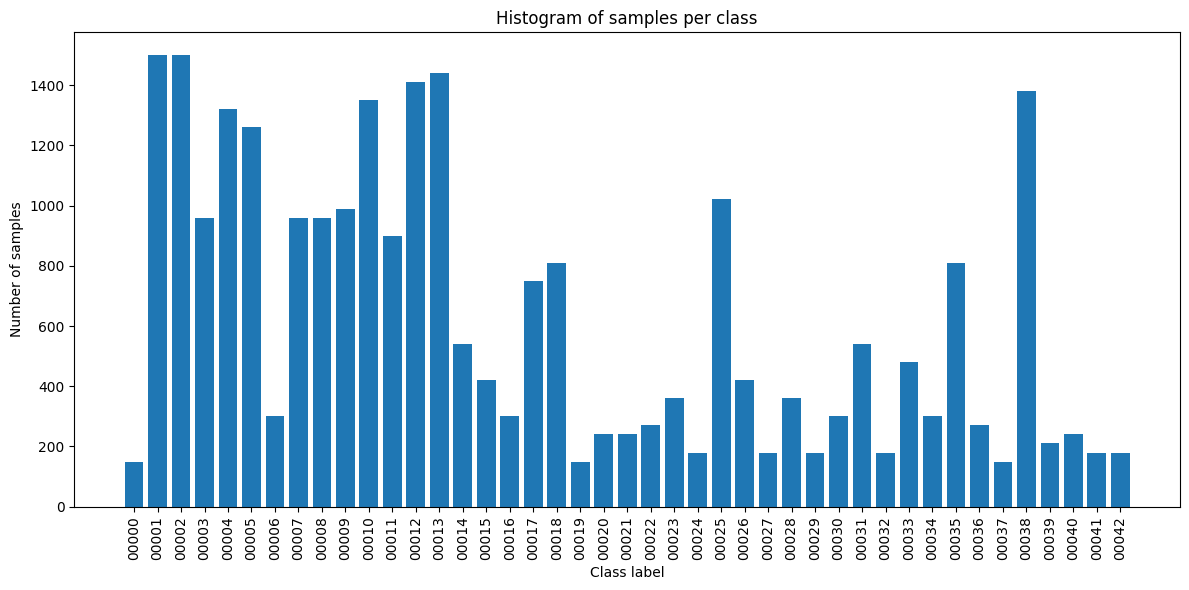

In [4]:
ppm_files = sorted(list_files_recursive(GTSRB_PATH, ".ppm"))
csv_files = sorted(list_files_recursive(GTSRB_PATH, ".csv"))

print(f'\nnumber of .ppm files: {len(ppm_files)},\nnumber of .csv files: {len(csv_files)}\n')

ppm_df = build_ppm_dataframe(ppm_files)
hist_df = plot_class_histogram_from_df(ppm_df)

In [5]:
ppm_df.head(10)

,class_label,series_number,image_number,filepath
0,00000,00000,00000,/tf/NEXTBASE/GTSRB/Training/00000/00000_00000.ppm
1,00000,00000,00001,/tf/NEXTBASE/GTSRB/Training/00000/00000_00001.ppm
2,00000,00000,00002,/tf/NEXTBASE/GTSRB/Training/00000/00000_00002.ppm
3,00000,00000,00003,/tf/NEXTBASE/GTSRB/Training/00000/00000_00003.ppm
4,00000,00000,00004,/tf/NEXTBASE/GTSRB/Training/00000/00000_00004.ppm
5,00000,00000,00005,/tf/NEXTBASE/GTSRB/Training/00000/00000_00005.ppm
6,00000,00000,00006,/tf/NEXTBASE/GTSRB/Training/00000/00000_00006.ppm
7,00000,00000,00007,/tf/NEXTBASE/GTSRB/Training/00000/00000_00007.ppm
8,00000,00000,00008,/tf/NEXTBASE/GTSRB/Training/00000/00000_00008.ppm
9,00000,00000,00009,/tf/NEXTBASE/GTSRB/Training/00000/00000_00009.ppm


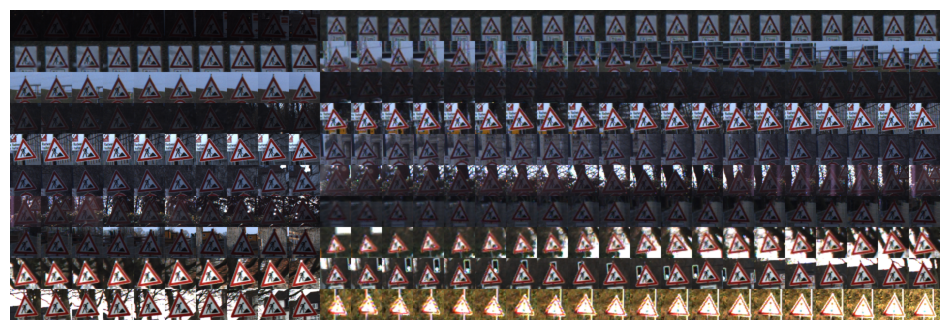

In [6]:
show_mosaic(ppm_files[20000:])

Train, validation, unlabelled and test data split:

In [7]:
#test dataset of N_samples_per_class random samples of each class, seed is fixed to obtain tha same samples each run of the notebook
dataset_partition_seed = 0
N_samples_per_class = 10

test_df = ppm_df.groupby("class_label").sample(n=N_samples_per_class, replace=False, random_state=dataset_partition_seed)

#remove test samples from dataframe
ppm_df = ppm_df.drop(test_df.index).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [8]:
#split the rest of the dataset into the labelled set 10% of each class samples
#pseudo - unlabeled dataset

partition_ratio = 0.1 #10% labelled DS, 90% unlabelled DS
sampled_list = []

# Iterate through each class
for class_label, group in ppm_df.groupby("class_label"):
    
    n_samples = max(1, int(len(group) * partition_ratio))
    
    # Randomly sample rows
    sampled = group.sample(n=n_samples, replace=False, random_state=dataset_partition_seed)
    sampled_list.append(sampled)

# Combine all sampled rows into one DataFrame
train_df = pd.concat(sampled_list, ignore_index=False)

# Remove sampled rows from the original DataFrame
unlabelled_df = ppm_df.drop(train_df.index).reset_index(drop=True)

# Reset index for the train set
train_df = train_df.reset_index(drop=True)

In [9]:
#split the the labelled dataset into the train/ validation datasets

partition_ratio = 0.2 #train / validation = 80%/20% ratio
sampled_list = []

# Iterate through each class
for class_label, group in train_df.groupby("class_label"):
    
    n_samples = max(1, int(len(group) * partition_ratio))
    
    # Randomly sample rows
    sampled = group.sample(n=n_samples, replace=False, random_state=dataset_partition_seed)
    sampled_list.append(sampled)

# Combine all sampled rows into one DataFrame
validation_df = pd.concat(sampled_list, ignore_index=False)

# Remove sampled rows from the original DataFrame
train_df = train_df.drop(validation_df.index).reset_index(drop=True)

# Reset index for the train set
validation_df = validation_df.reset_index(drop=True)

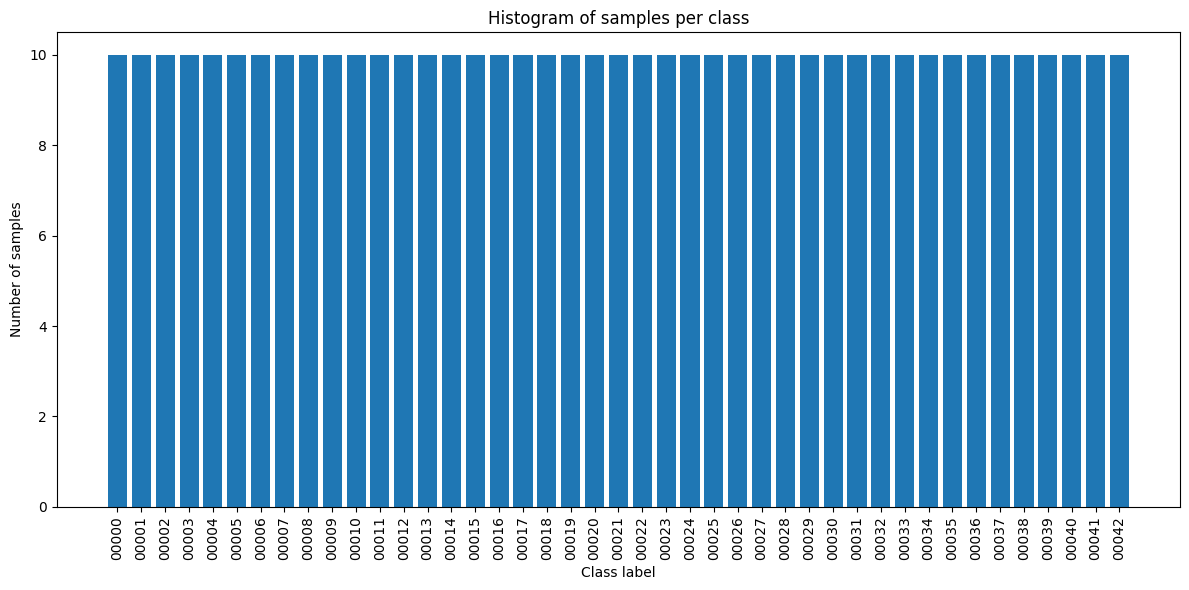

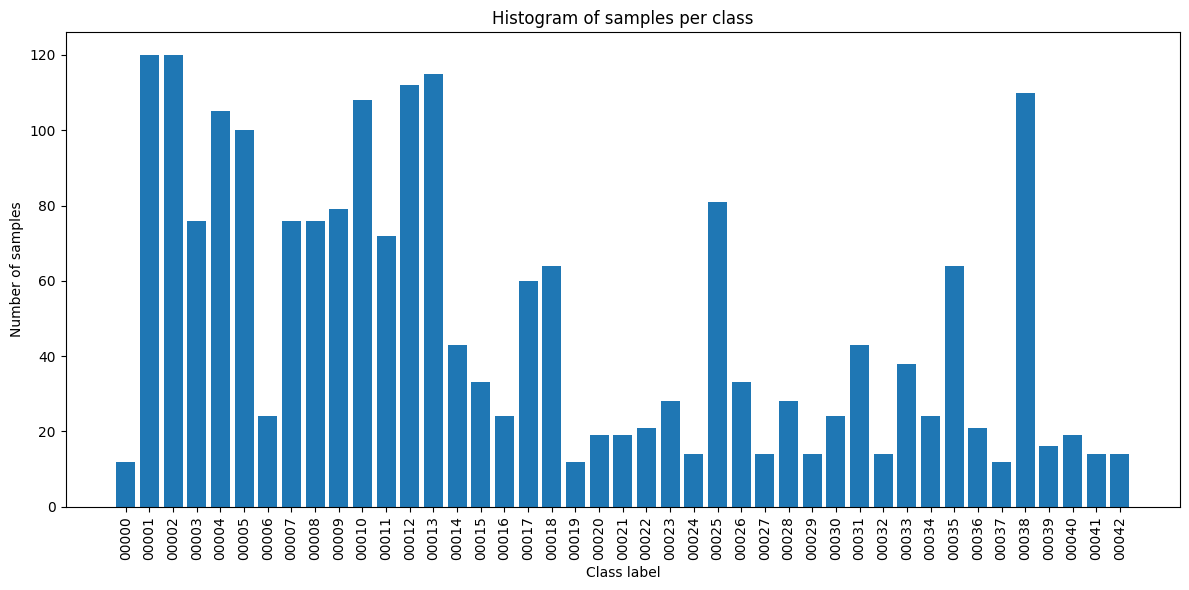

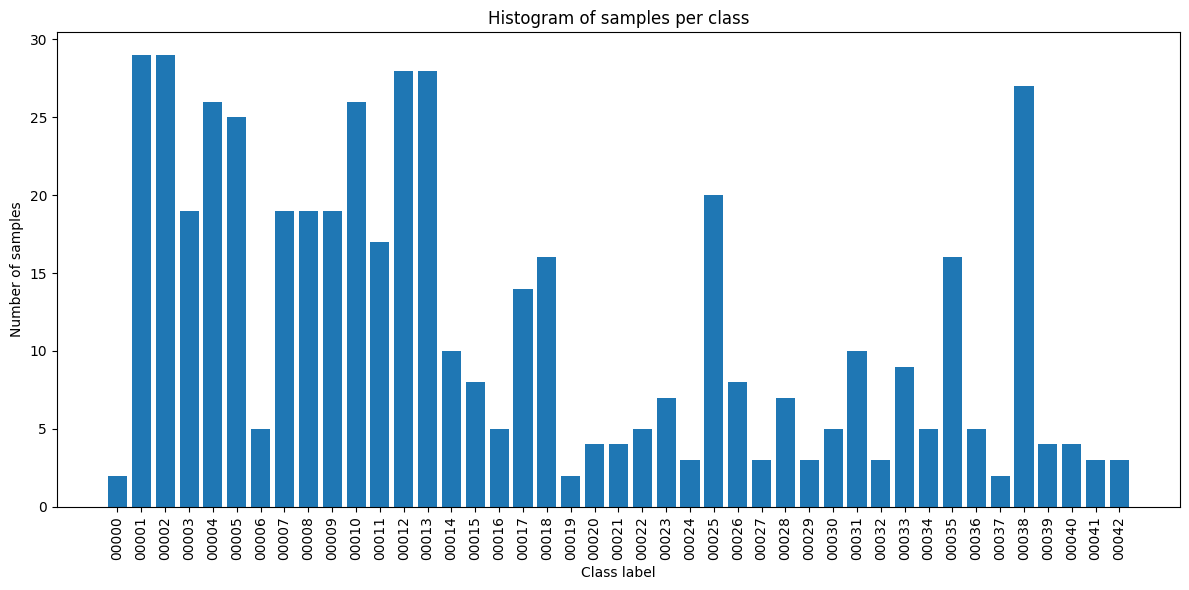

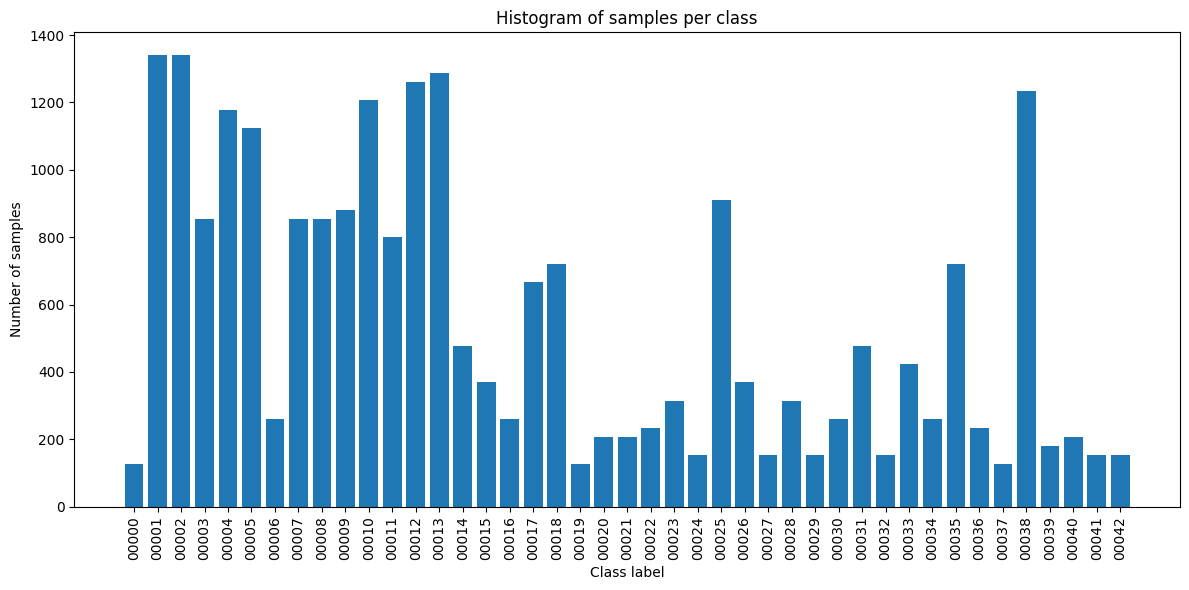

In [10]:
#show histogram of test set
test_df_hist = plot_class_histogram_from_df(test_df) 
train_df_hist = plot_class_histogram_from_df(train_df) 
validation_df_hist = plot_class_histogram_from_df(validation_df) 
unlabelled_df_hist = plot_class_histogram_from_df(unlabelled_df) 

In [11]:
#TF Dataset helper functions:
#loading image from file list into tf.data.Dataset
#resizing to the input size of pretrained Xception
#image range normalization to 0-1

Xception_image_size = 299

def load_ppm_image_pil(path, label):
    #opens a ppm v6 image file
    image = Image.open(path.numpy())   #why path.numpy()      
    image = image.resize((Xception_image_size, Xception_image_size))
    image = np.array(image) / 255.0        
    return image.astype(np.float32), label

# TensorFlow wrapper of load_ppm_image_pil
def tf_load_ppm(path, label):
    #wraps the image loadnig function to be used in Dataset mapping
    image, label = tf.py_function(func=load_ppm_image_pil,
                                  inp=[path, label],
                                  Tout=(tf.float32, tf.int64))
    image.set_shape([Xception_image_size, Xception_image_size, 3]) 
    label.set_shape([]) 
    return image, label

def get_dataset(df):
    '''
    makes a Dataset from a given dataframe

    '''
    file_paths = df['filepath'].values
    labels = df['class_label'].values.astype(int)
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(tf_load_ppm)

    # dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

def show_dataset(dataset): #shows images and labels from dataset   
    
    for images, labels in dataset.shuffle(1000).batch(32).take(1):
        print("Batch images shape:", images.shape)  # (batch_size, 128, 128, 3)
        print("Batch labels:", labels.numpy())
    
        plt.figure(figsize=(10, 5))
        for i in range(min(9, images.shape[0])):  
            plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy())
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis('off')
        plt.show()
        break



In [13]:
#create tf.data.Datasets from dataframes
train_dataset = get_dataset(train_df)
validation_dataset = get_dataset(validation_df)
test_dataset = get_dataset(test_df)
unlabelled_dataset = get_dataset(unlabelled_df)

2025-11-15 18:13:30.883802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-15 18:13:30.904433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-15 18:13:30.904623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
#baisic data augmentation transformations for training set

#more image intensity layers to be tested if more time aviable:
#may write own augmentation layers that will simulate motion blur 

#here we use augmentatnion to simulate changing real-life conditions of image acquisition:
#random rotation
#random zoom
#random translation

data_augmentation = tf.keras.Sequential([      
    tf.keras.layers.RandomRotation(0.1),               
    tf.keras.layers.RandomZoom(0.1),                   
    tf.keras.layers.RandomTranslation(0.1, 0.1)        
])

#model definition, feature xtractor is Google Xception with frozen layers 
inputs = tf.keras.layers.Input(shape=(Xception_image_size, Xception_image_size, 3))
x = tf.keras.applications.xception.preprocess_input(inputs)
base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_tensor=x)
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dropout(0.3)(x)  #lots of features, little data so dropout here
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.BatchNormalization()(x)  #optional BN layer
outputs = tf.keras.layers.Dense(43, activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

base_model.trainable = False




In [ ]:
#class weights computation as there is a significant inbalance in train dataset
y_train = train_df['class_label'].values.astype(int)
class_weights_values = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights_values)}

2025-11-15 18:13:35.867124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-11-15 18:13:37.142594: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xf24ff60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-15 18:13:37.142633: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-15 18:13:37.149254: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-15 18:13:37.233877: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 [==============================] - 48s 43ms/step - loss: 3.7590 - accuracy: 0.0308 - val_loss: 3.7657 - val_accuracy: 0.0178
Epoch 1/15
1000/1000 [==============================] - 70s 61ms/step - loss: 3.5583 - accuracy: 0.0934 - val_loss: 3.2697 - val_accuracy: 0.1601
Epoch 2/15
1000/1000 [==============================] - 61s 61ms/step - loss: 3.1428 - accuracy: 0.1832 - val_loss: 2.6565 - val_accuracy: 0.3083
Epoch 3/15
1000/1000 [==============================] - 61s 61ms/step - loss: 2.6763 - accuracy: 0.2878 - val_loss: 2.1683 - val_accuracy: 0.3379
Epoch 4/15
1000/1000 [==============================] - 60s 60ms/step - loss: 2.3055 - accuracy: 0.3680 - val_loss: 2.1343 - val_accuracy: 0.4565
Epoch 5/15
1000/1000 [==============================] - 61s 61ms/step - loss: 1.9601 - accuracy: 0.4481 - val_loss: 1.5389 - val_accuracy: 0.6087
Epoch 6/15
1000/1000 [==============================] - 60s 60ms/step - loss: 1.6402 - accuracy: 0.5031 - val_loss: 1.2715 - val_accura

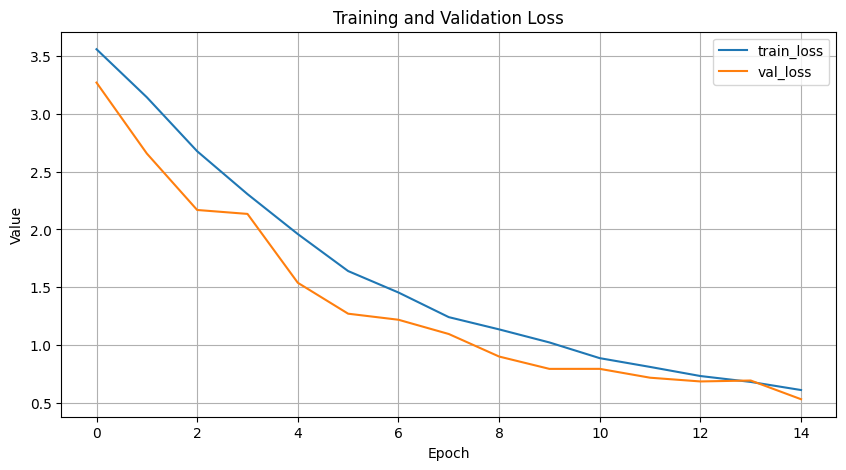

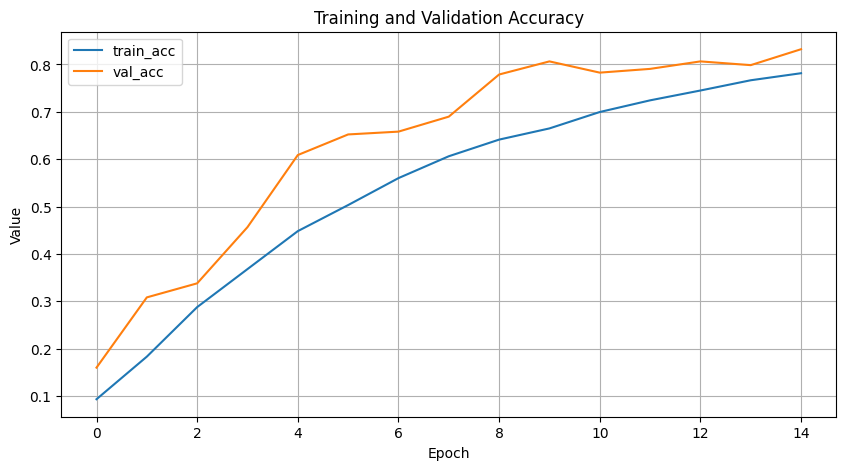

In [15]:
test_accuracy = []

#class weights i parametry Adama
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


#application of data augmentation directly to train_dataset,
#infinite set (repeat) because I use data augmentation
train_dataset = train_dataset.shuffle(1000).repeat().map(lambda x, y: (data_augmentation(x, training=True), y),
                              num_parallel_calls=tf.data.AUTOTUNE)

#first training run of only top dense layers to establish small gradient and small updates for fine tuning
history1 = model.fit(
    train_dataset.batch(8).prefetch(tf.data.AUTOTUNE),
    validation_data=validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
    epochs=1,
    class_weight=class_weights,
    steps_per_epoch=500
)

#top and middle Xception layers unlocked for training
for layer in base_model.layers:
    if layer.name.startswith(('block8','block9','block10','block11','block12','block13','block14')):
        layer.trainable = True

#compiling model for fine tuning runs with smaller LR 
optimizer_finetune = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer_finetune, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Fine-tuning
history = model.fit(
    train_dataset.batch(8).prefetch(tf.data.AUTOTUNE),
    validation_data=validation_dataset.batch(32).prefetch(tf.data.AUTOTUNE),
    epochs=15,
    class_weight=class_weights,
    steps_per_epoch=500
)

# loss / accuracy plots
plt.figure(figsize=(10,5))

# Loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
#test set evaluation
results = model.predict(test_dataset.batch(32))
y_pred = np.argmax(results, axis=1)
y_true = np.array([label.numpy() for _, label in test_dataset])

14/14 [==============================] - 2s 131ms/step


14/14 [==============================] - 2s 129ms/step - loss: 0.4716 - accuracy: 0.8605


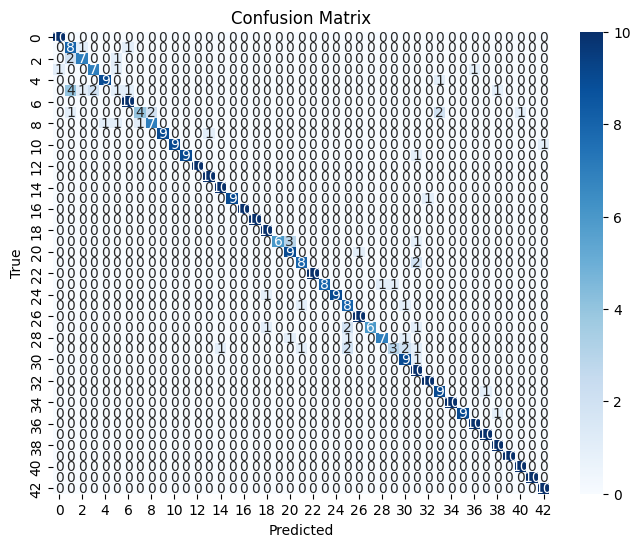

In [42]:
loss_test, accuracy_test = model.evaluate(test_dataset.batch(32))
test_accuracy.append(accuracy_test)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [17]:
- train Transfer learning - xception model
- use 10% of dataaset as lbeled dataset
- split into test, valid and test set


SyntaxError: invalid syntax (1276380873.py, line 1)